In [3]:
!pip install -U pip setuptools wheel
!pip install -U "matplotlib>=3.8" "seaborn>=0.13" pandas numpy

In [4]:
import matplotlib
print(matplotlib.__version__)  # should be >= 3.4

3.9.4


In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
# import seaborn as sns


In [80]:


# ---------- 1. Load JSON Lines file ----------
file_path = "../data/customer_churn.json"
df = pd.read_json(file_path, lines=True)

# ---------- 2. Convert timestamps ----------
df['datetime'] = pd.to_datetime(df['ts'], unit='ms', errors='coerce')
df['registration_datetime'] = pd.to_datetime(df['registration'], unit='ms', errors='coerce')

# ---------- 3. Add derived columns ----------
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour

# Days since registration
df['days_since_registration'] = (df['datetime'] - df['registration_datetime']).dt.days

# ---------- 4. Session duration (in minutes) ----------
session_duration = df.groupby('sessionId')['datetime'].agg(lambda x: (x.max() - x.min()).total_seconds() / 60)
df = df.merge(session_duration.rename('session_duration_min'), on='sessionId', how='left')

# ---------- 5. Extract browser & OS ----------
# Browser
df['agent_simple'] = df['userAgent'].str.extract(r'(Firefox|Chrome|Safari|Edge|MSIE|Opera)')
# OS
df['os_simple'] = df['userAgent'].str.extract(r'(Windows|Macintosh|Linux|iPhone|Android)')

# ---------- 6. Handle missing values ----------
# Keep NaNs for now; we’ll decide case-by-case in plotting
df['userId'] = df['userId'].replace('', np.nan)

# ---------- 7. Quick sanity check ----------
print(df.shape)
df.head()

(543705, 26)


,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,...,song,length,datetime,registration_datetime,date,hour,days_since_registration,session_duration_min,agent_simple,os_simple
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX",...,Grand Designs,597.55057,2018-10-01 00:00:11,2018-07-20 05:11:47,2018-10-01,0,72.0,44637.966667,Chrome,Macintosh
1,1538352025000,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX",...,Bulls,380.21179,2018-10-01 00:00:25,2018-09-27 17:33:58,2018-10-01,0,3.0,49953.833333,Chrome,Macintosh
2,1538352118000,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL",...,Because I Got High,202.37016,2018-10-01 00:01:58,2018-09-03 05:44:15,2018-10-01,0,27.0,18346.950000,Chrome,Macintosh
3,1538352119000,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL",...,NaN,NaN,2018-10-01 00:01:59,2018-09-03 05:44:15,2018-10-01,0,27.0,18346.950000,Chrome,Macintosh
4,1538352124000,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",...,Smile (Radio Edit),194.53342,2018-10-01 00:02:04,2018-09-02 23:30:18,2018-10-01,0,28.0,39693.983333,Firefox,Windows


# Step 2 — Dataset-level Plots


In [81]:
# 2.0 Overall Number of Unique Users
total_users = df['userId'].nunique()
print(f"🧑‍💻 Total unique users: {total_users}")

🧑‍💻 Total unique users: 448


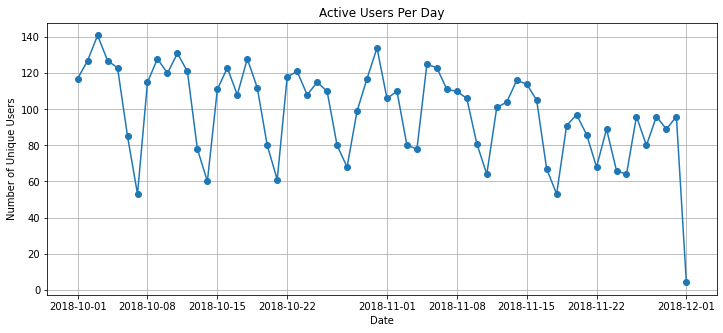

In [82]:
## 2.1 Active Users Per Day


active_users_per_day = df.groupby('date')['userId'].nunique()

plt.figure(figsize=(12, 5))
active_users_per_day.plot(marker='o')
plt.title("Active Users Per Day")
plt.ylabel("Number of Unique Users")
plt.xlabel("Date")
plt.grid(True)
plt.show()

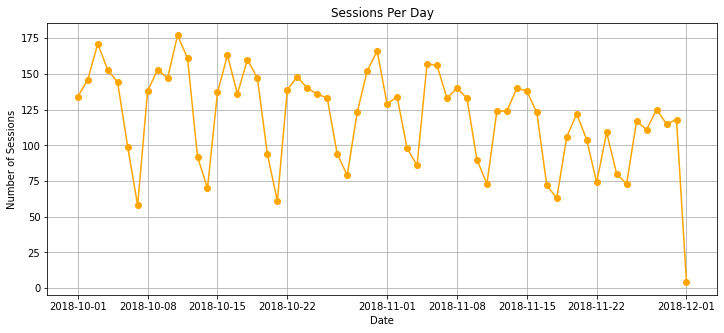

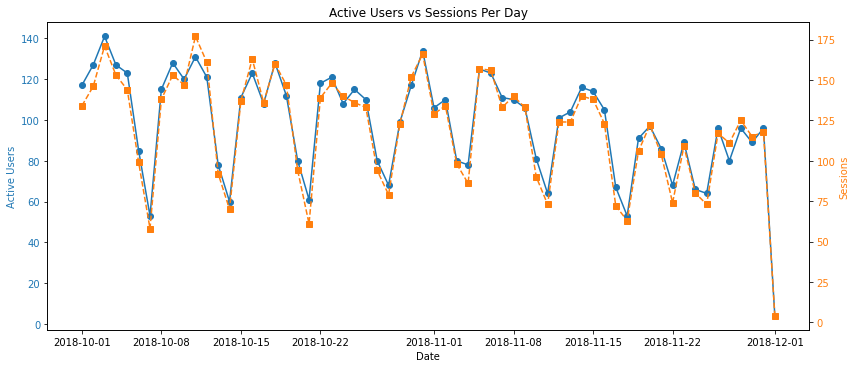

In [83]:
# 2.2 Sessions Per Day

sessions_per_day = df.groupby('date')['sessionId'].nunique()

plt.figure(figsize=(12, 5))
sessions_per_day.plot(marker='o', color='orange')
plt.title("Sessions Per Day")
plt.ylabel("Number of Sessions")
plt.xlabel("Date")
plt.grid(True)
plt.show()

fig, ax1 = plt.subplots(figsize=(12,5))

color1 = 'tab:blue'
color2 = 'tab:orange'

ax1.set_xlabel("Date")
ax1.set_ylabel("Active Users", color=color1)
ax1.plot(active_users_per_day.index, active_users_per_day.values, color=color1, marker='o', label="Active Users")
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
ax2.set_ylabel("Sessions", color=color2)
ax2.plot(sessions_per_day.index, sessions_per_day.values, color=color2, marker='s', linestyle='--', label="Sessions")
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.title("Active Users vs Sessions Per Day")
plt.show()

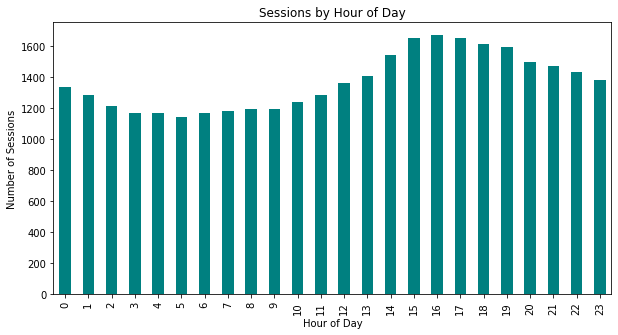

In [84]:
# 2.3 Sessions by Hour of Day
sessions_by_hour = df.groupby('hour')['sessionId'].nunique()

plt.figure(figsize=(10, 5))
sessions_by_hour.plot(kind='bar', color='teal')
plt.title("Sessions by Hour of Day")
plt.ylabel("Number of Sessions")
plt.xlabel("Hour of Day")
plt.show()

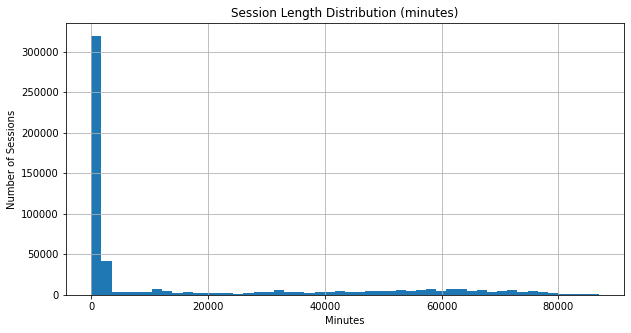

In [85]:
# 2.4 Session Length Distribution

plt.figure(figsize=(10, 5))
df['session_duration_min'].dropna().hist(bins=50)
plt.title("Session Length Distribution (minutes)")
plt.xlabel("Minutes")
plt.ylabel("Number of Sessions")
plt.show()

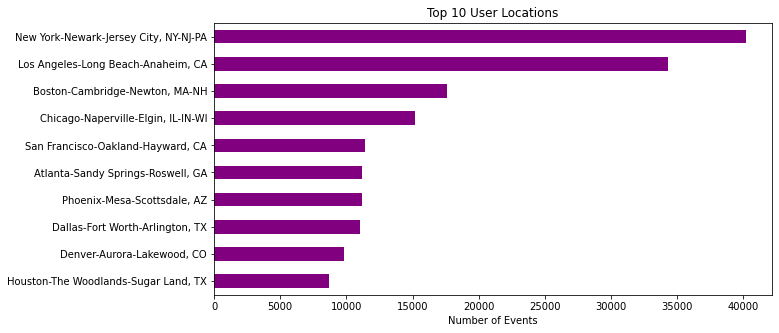

In [86]:
# 2.5 Top 10 Locations

top_locations = df['location'].value_counts().head(10)

plt.figure(figsize=(10, 5))
top_locations.plot(kind='barh', color='purple')
plt.title("Top 10 User Locations")
plt.xlabel("Number of Events")
plt.gca().invert_yaxis()
plt.show()

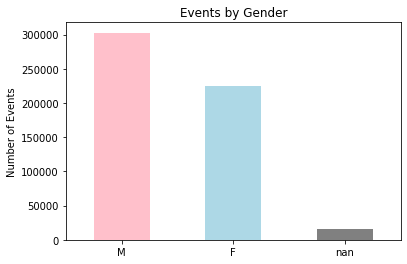

In [87]:
# 2.6 Gender Distribution — Events
gender_counts = df['gender'].value_counts(dropna=False)

plt.figure(figsize=(6,4))
gender_counts.plot(kind='bar', color=['pink', 'lightblue', 'gray'])
plt.title("Events by Gender")
plt.ylabel("Number of Events")
plt.xticks(rotation=0)
plt.show()

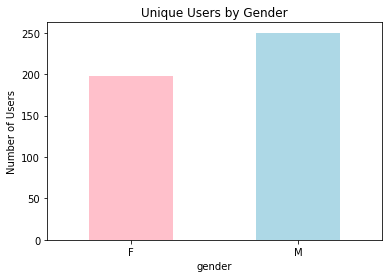

In [88]:
# 2.7 Gender Distribution — Unique Users

gender_users = df.groupby('gender')['userId'].nunique()

plt.figure(figsize=(6,4))
gender_users.plot(kind='bar', color=['pink', 'lightblue', 'gray'])
plt.title("Unique Users by Gender")
plt.ylabel("Number of Users")
plt.xticks(rotation=0)
plt.show()

# Step 3 — Page-level Visualizations


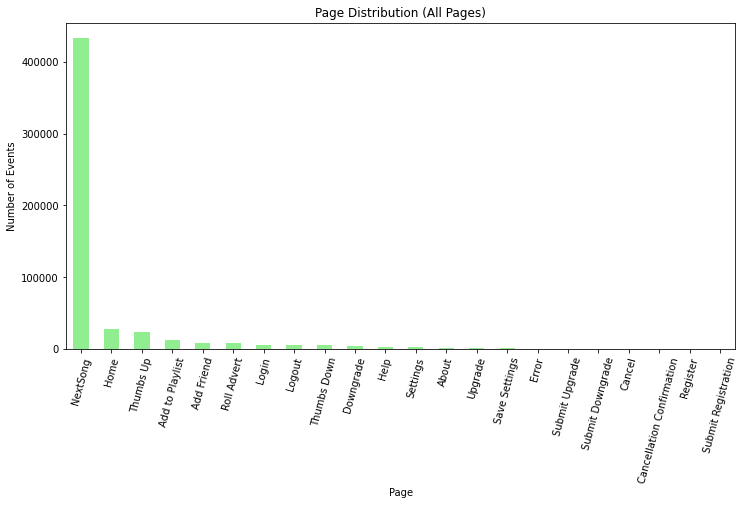

In [89]:
# 3.1 Page Distribution

plt.figure(figsize=(12,6))
df['page'].value_counts().plot(kind='bar', color='lightgreen')
plt.title("Page Distribution (All Pages)")
plt.ylabel("Number of Events")
plt.xlabel("Page")
plt.xticks(rotation=75)
plt.show()

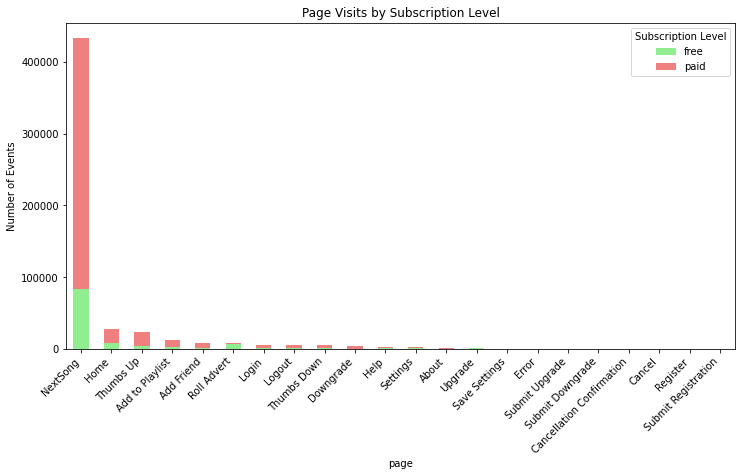

In [92]:
# 3.2 Page Distribution by Subscription Level

# Count per page per level
page_level_counts = df.groupby(['page', 'level']).size().unstack(fill_value=0)

# Plot stacked bars
page_level_counts = page_level_counts.loc[page_level_counts.sum(axis=1).sort_values(ascending=False).index]

page_level_counts.plot(kind='bar', stacked=True, figsize=(12,6), color=['lightgreen', 'lightcoral'])
plt.title("Page Visits by Subscription Level")
plt.ylabel("Number of Events")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Subscription Level")
plt.show()

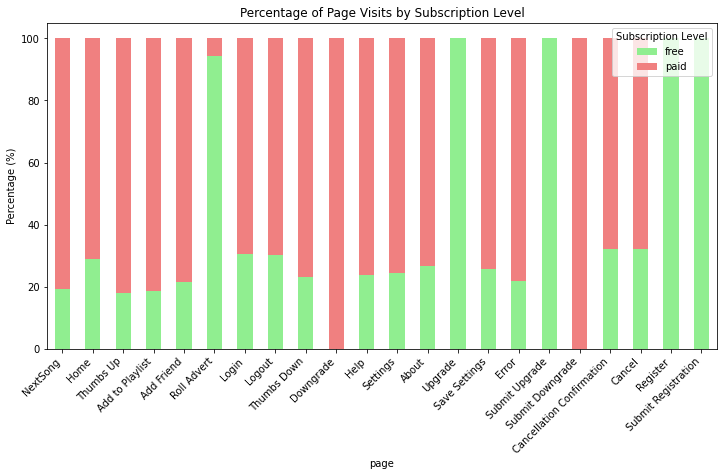

In [93]:
# 3.3 Percentage of Page Visits by Level

page_level_pct = page_level_counts.div(page_level_counts.sum(axis=1), axis=0) * 100

page_level_pct.plot(kind='bar', stacked=True, figsize=(12,6), color=['lightgreen', 'lightcoral'])
plt.title("Percentage of Page Visits by Subscription Level")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Subscription Level")
plt.show()

# Step 4 — User-level Visualizations


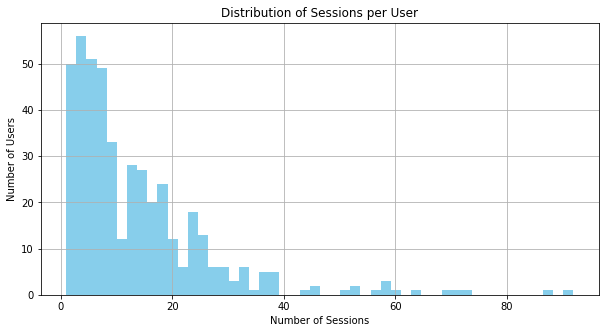

In [97]:
# 4.1 Number of Sessions per User

sessions_per_user = df.groupby('userId')['sessionId'].nunique().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sessions_per_user.hist(bins=50, color='skyblue')
plt.title("Distribution of Sessions per User")
plt.xlabel("Number of Sessions")
plt.ylabel("Number of Users")
plt.show()

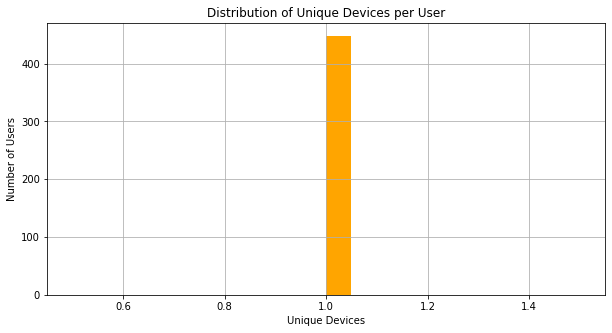

In [98]:
# 4.2 Number of Unique Devices per User

devices_per_user = df.groupby('userId')['userAgent'].nunique()

plt.figure(figsize=(10,5))
devices_per_user.hist(bins=20, color='orange')
plt.title("Distribution of Unique Devices per User")
plt.xlabel("Unique Devices")
plt.ylabel("Number of Users")
plt.show()

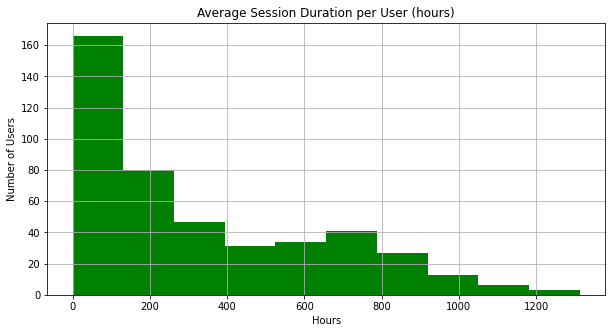

In [102]:
# 4.3 Average Session Duration per User

avg_session_duration_per_user = df.groupby('userId')['session_duration_min'].mean() // 60

plt.figure(figsize=(10,5))
avg_session_duration_per_user.hist(bins=10, color='green')
plt.title("Average Session Duration per User (hours)")
plt.xlabel("Hours")
plt.ylabel("Number of Users")
plt.show()

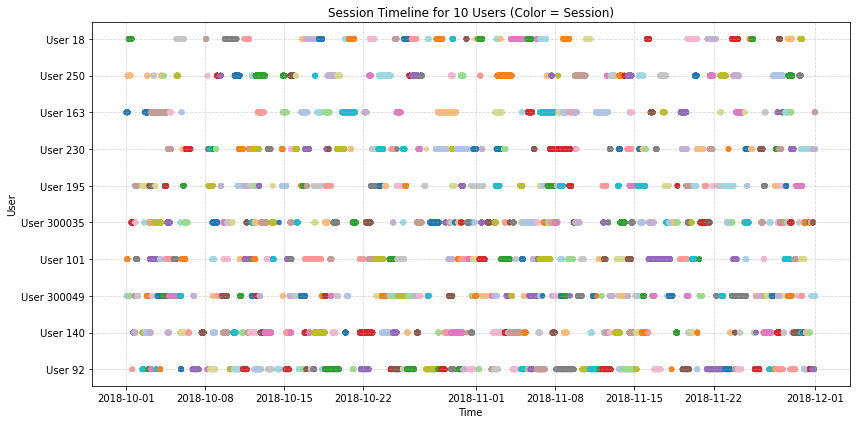

In [ ]:
# 4.4 Multi-User Session Timeline

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Choose N random users with enough activity
N = 10
active_users = df['userId'].dropna().value_counts().head(N).index
df_subset = df[df['userId'].isin(active_users)].copy()

# Sort by datetime
df_subset = df_subset.sort_values('datetime')

# Map each sessionId to a color
unique_sessions = df_subset['sessionId'].unique()
colors = cm.tab20.colors  # color palette
session_color_map = {sid: colors[i % len(colors)] for i, sid in enumerate(unique_sessions)}

plt.figure(figsize=(12, 6))

# Plot each user’s sessions
for idx, user in enumerate(active_users):
    user_data = df_subset[df_subset['userId'] == user]
    plt.scatter(
        user_data['datetime'],
        [idx] * len(user_data),
        c=user_data['sessionId'].map(session_color_map),
        label=f"User {user}",
        s=20
    )

plt.yticks(range(N), [f"User {u}" for u in active_users])
plt.xlabel("Time")
plt.ylabel("User")
plt.title(f"Session Timeline for {N} Users (Color = Session)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()